In [76]:
import pandas as pd
from pandas.io import sql
from sqlalchemy import create_engine
from sqlalchemy.pool import Pool
from datetime import datetime
import mysql.connector
import json
import csv
import os

import numpy as np
import pymysql as mysql
import matplotlib.pyplot as plt
import requests
import getpass

#!pip install mysql-connector-python

In [ ]:
###############################################
# Cleaning the Data
###############################################

# Extract the Data 

In [77]:
#extract the data 


go_1k = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_1k.csv"))
go_daily_sales = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_daily_sales.csv"))
go_methods = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_methods.csv"))
go_products = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_products.csv"))
go_retailers = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/go_retailers.csv"))
cpi_monthly = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/1_month_percent_change_in_CPI.csv"))
unemploy_monthly = pd.DataFrame(pd.read_csv("https://github.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/raw/main/GOSales_data/Monthly_unemployment_rate.csv"))
cci_monthly = pd.DataFrame(pd.read_csv("https://raw.githubusercontent.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/main/GOSales_data/CCI%20CSV.csv"))
gdp_monthly = pd.DataFrame(pd.read_csv("https://raw.githubusercontent.com/RenettaNelson/ADS-507---SQL-Data-Pipeline/main/GOSales_data/US_Monthly_GDP.csv"))


In [ ]:
go_1k.head()

In [ ]:
go_daily_sales.head()

In [ ]:
cci_monthly.head()

In [ ]:
go_products.head()

In [ ]:
go_retailers.head()

In [ ]:
cpi_monthly.head()

In [ ]:
unemploy_monthly.head()

In [78]:

gdp_monthly.head()


,Unnamed: 0,Monthly Nominal GDP Index,Monthly Real GDP Index
0,1992 - Jan,6315.583,9485.863
1,1992 - Feb,6356.697,9527.954
2,1992 - Mar,6417.025,9606.158
3,1992 - Apr,6443.138,9612.297
4,1992 - May,6433.851,9594.432


# Data Transformation

In [79]:
# Transform GDP dataframe to usable table

gdp_monthly = gdp_monthly.drop("Monthly Nominal GDP Index", axis = 1)
gdp_monthly.rename(columns = {'Unnamed: 0': 'Date'}, inplace=True)
gdp_monthly['Date'] = pd.to_datetime(gdp_monthly['Date'])
gdp_monthly['Date'] = gdp_monthly['Date'].dt.strftime('%Y-%m')
gdp_monthly = gdp_monthly.drop(range(0,276))
gdp_monthly = gdp_monthly.drop(range(300, 372))

gdp_monthly

,Date,Monthly Real GDP Index
276,2015-01,17274.838
277,2015-02,17353.545
278,2015-03,17213.689
279,2015-04,17389.551
280,2015-05,17349.749
281,2015-06,17403.536
282,2015-07,17403.909
283,2015-08,17407.732
284,2015-09,17499.930
285,2015-10,17488.269


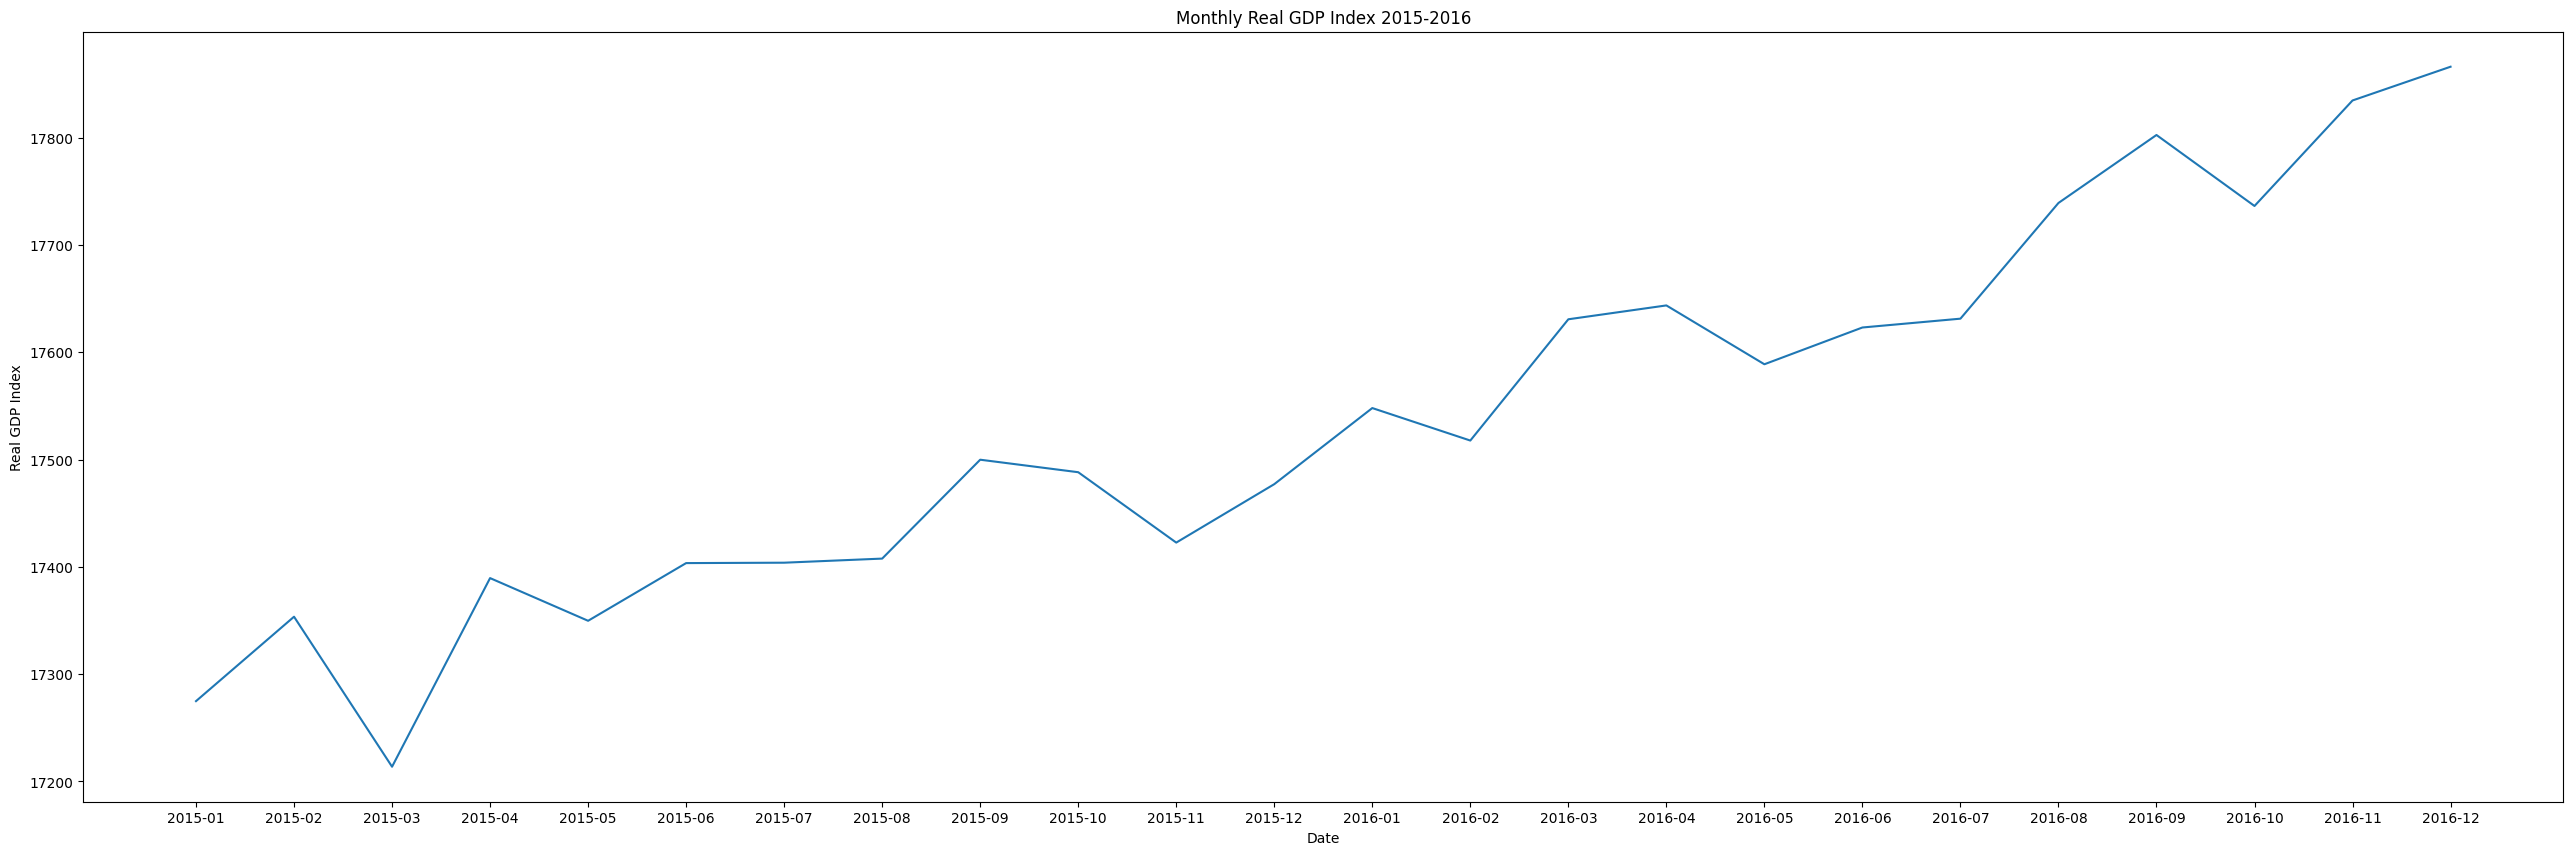

In [80]:
f = plt.figure()
f.set_figwidth(32)
f.set_figheight(10)


plt.plot(gdp_monthly['Date'], gdp_monthly['Monthly Real GDP Index'])
plt.xlabel("Date")
plt.ylabel("Real GDP Index")
plt.title("Monthly Real GDP Index 2015-2016")
plt.show() 

In [ ]:
#Modify cci table to add year and month column
cci_monthly['Year'] = pd.DatetimeIndex(cci_monthly['TIME']).year
cci_monthly['Month'] = pd.DatetimeIndex(cci_monthly['TIME']).month
cci_monthly.head()

In [ ]:
#add year and month column to go_daily_sales
go_daily_sales['Year'] = pd.DatetimeIndex(go_daily_sales['Date']).year
go_daily_sales['Month'] = pd.DatetimeIndex(go_daily_sales['Date']).month
go_daily_sales.head()

In [ ]:
#add year and month column to go_1k
go_1k['Year'] = pd.DatetimeIndex(go_1k['Date']).year
go_1k['Month'] = pd.DatetimeIndex(go_1k['Date']).month
go_1k.head()

In [ ]:
#remove spaces from column names and insert '_'
def spaces(df):
    df.columns = df.columns.str.replace(' ', '_')
    return df.head()

data = [go_1k, go_daily_sales, go_methods, go_products, go_retailers, unemploy_monthly, cpi_monthly, cci_monthly]
for i in data:
    spaces(i)

In [ ]:
cci_monthly = cci_monthly.rename(columns={"TIME": "Date"})

In [ ]:
### drop flag codes columns due to NAN and irrelevance
cci_monthly = cci_monthly.drop(['Flag Codes', 'LOCATION', 'INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Date'], axis=1)

In [ ]:
go_1k = go_1k.drop(['Date'], axis=1)

In [ ]:
#Transpose monthly unemployment data
unemployment_monthly = unemploy_monthly.T.set_axis(unemploy_monthly['Year'], axis=1, inplace=False)
unemployment_monthly = unemployment_monthly.drop('Year')
unemployment_monthly.index.names = ['Month']
unemployment_monthly = pd.DataFrame(unemployment_monthly)
unemployment_monthly

In [ ]:
#Transpose monthly cpi data
cpi_monthly_t = cpi_monthly.T.set_axis(cpi_monthly['Year'], axis=1, inplace=False)
cpi_monthly_t = cpi_monthly_t.drop(['Year', 'HALF1',"HALF2"])
cpi_monthly_t.index.names = ['Month']
cpi_monthly_t = pd.DataFrame(cpi_monthly_t)
cpi_monthly_t

In [ ]:
test = pd.merge(cci_monthly, go_1k, how='inner',
                 left_on=['Month', 'Year'],
                 right_on=['Month', 'Year'])
test.head()

In [ ]:
test.head()

In [ ]:
test.head()

# Load transformed tables to destination database

In [ ]:
# Connect to the sql server
connection = mysql.connect(host='localhost',
                         user='root',
                         password=getpass.getpass(prompt='Password:',stream=None))
                          

# create cursor
cursor = connection.cursor()

In [ ]:
#Create Database
cursor.execute("CREATE DATABASE wild_wonderful_sales")

In [ ]:
#create engine to add data to sql database "gosales"
db_data = 'mysql+mysqlconnector://' + 'root' + ':' + getpass.getpass(prompt='Password:',stream=None) + '@' + 'localhost' + ':3306/' \
       + 'wild_wonderful_sales' + '?charset=utf8mb4'
engine = create_engine(db_data)

In [ ]:
def load(df, table):
    df.to_sql(table, engine, if_exists='append', index=False)

df = [go_1k, go_daily_sales, go_methods, go_products, go_retailers, unemployment_monthly, cpi_monthly_t, cci_monthly]
tables = ['go_1k', 'go_daily_sales', 'go_methods', 'go_products', 'go_retailers', 'unemployment_monthly', 'cpi_monthly_t', 'cci_monthly']

for i, j in zip(df, tables):
    load(i, j)
print('Tables loaded sucessfully :)')

In [ ]:
#update connection to use go sales database
connection = mysql.connect(host='localhost',
                         user='root',
                         password=getpass.getpass(prompt='Password:',stream=None),
                         database='wild_wonderful_sales')

#Begin Queries

In [ ]:
#Total product sales by volume
product_vol = pd.DataFrame(pd.read_sql("SELECT s.Quantity,\
                                               p.Product \
                                        FROM go_daily_sales s \
                                            JOIN go_products p \
                                            ON s.Product_number = p.Product_number \
                                        GROUP BY Product \
                                        ORDER BY Quantity DESC \
                                        LIMIT 20;", 
                                        connection))
product_vol

In [ ]:
go_daily_sales['Revenue'] = go_daily_sales['Unit_price'] * go_daily_sales['Quantity']
monthly_sales = pd.DataFrame(go_daily_sales[['Month', 'Year', 'Revenue']])
monthly_sales.head()

In [ ]:
sales = pd.DataFrame(monthly_sales.groupby(['Month', 'Year'], as_index=False)['Revenue'].sum())
monthly_sales_2015 = pd.DataFrame(sales[sales.Year ==2015])
monthly_sales_2015

In [ ]:
monthly_sales_2016 = pd.DataFrame(sales[sales.Year ==2016])
monthly_sales_2016

##Create table for monthly unemployment in 2015 and 2016

##Create table for monthly consumer price index change in 2015 and 2016

In [ ]:
cpi_monthly_2015_2016 = cpi_monthly.T.set_axis(cpi_monthly['Year'], axis=1, inplace=False)
cpi_monthly_2015_2016 = cpi_monthly_2015_2016.drop(['Year', 'HALF1',"HALF2"])
cpi_monthly_2015_2016.index.names = ['Month']
cpi_monthly_2015_2016 = pd.DataFrame(cpi_monthly_2015_2016[[2015, 2016]])
cpi_monthly_2015_2016

In [ ]:
connection.close()